This notebook aims to investigate the distribution of lightning in the Arctic.

Input:

- monthly OTD lightning data: [LISOTD_HRMC_V2.3.2015.nc](http://dx.doi.org/10.5067/LIS/LIS-OTD/DATA303)
- GLD360 stroke data: gld_stroke_summer.nc and gld-stroke-count-m0p1.csv (generated by [`gld360_summer.py`](https://github.com/zxdawn/S5P-LNO2/blob/main/main/gld360_summer.py))
- GLD360 strokes inside TROPOMI swaths during the 3 hours before TROPOMI overpass (generated by [`lightning_in_swath.py`](https://github.com/zxdawn/S5P-LNO2/blob/main/main/lightning_in_swath.py))

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from glob import glob
import proplot as pplt
import cartopy.crs as ccrs
from pyproj import Geod
from functools import lru_cache
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import PercentFormatter
from matplotlib.colors import LogNorm
from scipy import stats

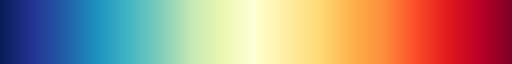

In [2]:
# create colormap
cmap = pplt.Colormap('YlGnBu_r', 'YlOrRd', ratios=(1, 1), name='tropomi_no2')
cmap

## Read data

### OTD monthly lightning density

In [3]:
ds_otd = xr.open_dataset('../data/otd/LISOTD_HRMC_V2.3.2015.nc', decode_times=False)

# Flashes km-2 mon-1
otd_mon = ds_otd.where(ds_otd['Latitude'] > 60, drop=True).sel(Month=slice(6, 8)).mean(dim='Month')['HRMC_COM_FR']*30

### GLD360 summer lightning

#### 0.5 deg area

In [4]:
lon_bnds = np.arange(-180, 180.5, 0.5)
lat_bnds = np.arange(60, 90.5, 0.5)
lon_bounds2d, lat_bounds2d = np.meshgrid(lon_bnds, lat_bnds)

@lru_cache(maxsize=2**10)
def calc_area():
    """Calculate area of each pixel"""
    geod = Geod(ellps="WGS84")

    len_x = lon_bounds2d.shape[0]-1
    len_y = lon_bounds2d.shape[1]-1
    area = np.full((len_x, len_y), 0)

    for x in range(len_x):
        for y in range(len_y):
            # get the corner coordinates
            lons = lon_bounds2d[x:x+2, y:y+2].ravel()
            lats = lat_bounds2d[x:x+2, y:y+2].ravel()

            # clockwise direction
            lons[-2], lons[-1] = lons[-1], lons[-2]
            lats[-2], lats[-1] = lats[-1], lats[-2]

            # get the area
            poly_area, poly_perimeter = geod.polygon_area_perimeter(lons, lats)
            area[x, y] = poly_area

    return xr.DataArray(area, dims=['latitude', 'longitude'],
                        coords={'longitude': lon_bnds[:-1], 'latitude': lat_bnds[:-1]})

area_05deg = calc_area()

In [5]:
# Strokes km-2 mo-1
gld360_summer = xr.open_dataset('../data/gld360/gld_stroke_summer.nc').coarsen(longitude=5, latitude=5).sum().groupby("time.season").mean().sel(season='JJA')/area_05deg.transpose('longitude', 'latitude').values*1e6
gld360_summer_2019 = xr.open_dataset('../data/gld360/gld_stroke_summer.nc').coarsen(longitude=5, latitude=5).sum().sel(time="2019").groupby("time.season").mean().sel(season='JJA')/area_05deg.transpose('longitude', 'latitude').values*1e6
gld360_summer_2020 = xr.open_dataset('../data/gld360/gld_stroke_summer.nc').coarsen(longitude=5, latitude=5).sum().sel(time="2020").groupby("time.season").mean().sel(season='JJA')/area_05deg.transpose('longitude', 'latitude').values*1e6
gld360_summer_2021 = xr.open_dataset('../data/gld360/gld_stroke_summer.nc').coarsen(longitude=5, latitude=5).sum().sel(time="2021").groupby("time.season").mean().sel(season='JJA')/area_05deg.transpose('longitude', 'latitude').values*1e6

# corrected stroke considering the detection efficiency
gld360_summer *= 4
gld360_summer_2019 *= 4
gld360_summer_2020 *= 4
gld360_summer_2021 *= 4

In [6]:
df_lightning = pd.read_csv('../data/gld360/gld-stroke-count-m0p1.csv')
df_lightning.set_index(['time'], inplace=True)
df_lightning.index = pd.to_datetime(df_lightning.index)

# corrected by detection efficiency and IC:CG ratio (~1)
df_lightning['eventCount'] *= 4

# calculate monthly GLD360 strokes in different regions
rule = 'M'
lightning_60 = df_lightning[(df_lightning['latitude'] >= 60)]['eventCount'].resample(rule, label='left', closed='left').sum().reindex(pd.date_range('2019-01-01', '2021-12-31', freq='M'))
lightning_70 = df_lightning[(df_lightning['latitude'] >= 70)]['eventCount'].resample(rule, label='left', closed='left').sum().reindex(pd.date_range('2019-01-01', '2021-12-31', freq='M'))
lightning_80 = df_lightning[(df_lightning['latitude'] >= 80)]['eventCount'].resample(rule, label='left', closed='left').sum().reindex(pd.date_range('2019-01-01', '2021-12-31', freq='M'))

### Lightning within swath 3 hours before TROPOMI overpass

In [7]:
df_swath = pd.concat(map(pd.read_csv, glob('../data/lno2/swath_lightning_*.csv')))

In [8]:
# create target grid, increase the resolution higher than 0.05 will get more accurate results
lon_resolution = 0.5
lat_resolution = 0.5
lon_bnd = np.arange(-180, 180+lon_resolution, lon_resolution)
lat_bnd = np.arange(60, 90+lat_resolution, lat_resolution)
lon_center = np.convolve(lon_bnd, np.ones(2), 'valid') / 2
lat_center = np.convolve(lat_bnd, np.ones(2), 'valid') / 2

In [9]:
lightning_swath = xr.DataArray(stats.binned_statistic_2d(df_swath['longitude'], df_swath['latitude'], None,
                                        'count', bins=[lon_bnd, lat_bnd]).statistic,
                                        dims=['longitude', 'latitude'],
                                        coords={'latitude': lat_center, 'longitude': lon_center}).rename('lightning_swath').astype('int')

lightning_swath *= 4

In [10]:
lightning_swath_summer = lightning_swath/area_05deg.transpose('longitude', 'latitude').values*1e6/9
lightning_swath_summer

<xarray.DataArray 'lightning_swath' (longitude: 720, latitude: 60)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00029719, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00029719, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.00204807, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])
Coordinates:
  * latitude   (latitude) float64 60.25 60.75 61.25 61.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8

#### Monthly data

In [11]:
df_swath['Date'] = pd.to_datetime(df_swath.timestamp)

lightning_swath_monthly = df_swath[df_swath.Date.dt.month.isin([6,7,8])]
# assign same left date as before
time_index = pd.date_range('2019-05-01', '2019-07-31', freq='M').union(pd.date_range('2020-05-01', '2020-07-31', freq='M')).union(pd.date_range('2021-05-01', '2021-07-31', freq='M'))

# take care of the label and closed
#   https://stackoverflow.com/a/50446286/7347925
lightning_swath_60 = lightning_swath_monthly[lightning_swath_monthly['latitude']>=60]
lightning_swath_60 = lightning_swath_60.resample('M', on='Date', label='left', closed='left').size()*4
lightning_swath_60 = lightning_swath_60[lightning_swath_60.index.isin(time_index)]

lightning_swath_70 = lightning_swath_monthly[lightning_swath_monthly['latitude']>=70]
lightning_swath_70 = lightning_swath_70.resample('M', on='Date', label='left', closed='left').size()*4
lightning_swath_70 = lightning_swath_70[lightning_swath_70.index.isin(time_index)]

lightning_swath_80 = lightning_swath_monthly[lightning_swath_monthly['latitude']>=80]
lightning_swath_80 = lightning_swath_80.resample('M', on='Date', label='left', closed='left').size()*4
lightning_swath_80 = lightning_swath_80[lightning_swath_80.index.isin(time_index)]


In [12]:
lightning_swath_percent_60 = ((lightning_swath_60-lightning_swath_70)/(lightning_60-lightning_70).loc[time_index])
lightning_swath_percent_70 = ((lightning_swath_70-lightning_swath_80)/(lightning_70-lightning_80).loc[time_index])
lightning_swath_percent_80 = (lightning_swath_80/lightning_80.loc[time_index])

df_lightning_swath_percent = pd.DataFrame(np.stack((lightning_swath_percent_60, lightning_swath_percent_70, lightning_swath_percent_80)).T,
            index=(time_index+pd.Timedelta('1D')).strftime('%Y-%m'),
            columns=['60-70','70-80','80-90'])

## Plot the lightning distribution

In [13]:
def plot_otd(otd_mon, ax, vmax=1):
    m = ax.pcolormesh(otd_mon['Longitude'], otd_mon['Latitude'], otd_mon, cmap=cmap, vmin=0, vmax=vmax, discrete=False,
                     cmap_kw={'left': 0.05, 'right': 0.95})
    ax.colorbar([m], loc='b', extend='max', label='Flash rate (# km$^{-2}$ month$^{-1}$)')
    ax.format(title='1996-1999')


def plot_lightning_geo(lightning_summer, ax, title, vmax=1):
    """Plot the geo distribution of summed count"""
    lats, lons = np.meshgrid(lightning_summer['latitude'], lightning_summer['longitude'])

    m = ax.pcolormesh(lons, lats, lightning_summer.where(lightning_summer>0),
                      vmin=0, vmax=vmax, extend='max', cmap=cmap, discrete=False,
                      cmap_kw={'left': 0.05, 'right': 0.95})

    ax.colorbar([m], loc='b', label='Stroke rate (# km$^{-2}$ month$^{-1}$)')
    ax.format(title=title)

/var/folders/cq/3gpzzbcn09v0cq17f4n6hjcr0000gn/T/ipykernel_10220/2831282764.py:29: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axs[:3].stock_img()
/var/folders/cq/3gpzzbcn09v0cq17f4n6hjcr0000gn/T/ipykernel_10220/2831282764.py:41: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axs[:3].text(-42, 66, '70$^{\circ}$ N', rotation=-45, transform=ccrs.PlateCarree())
/var/folders/cq/3gpzzbcn09v0cq17f4n6hjcr0000gn/T/ipykernel_10220/2831282764.py:42: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axs[:3].text(-42, 76, '80$^{\circ}$ N', rotation=-45, transform=ccrs.PlateCarree())


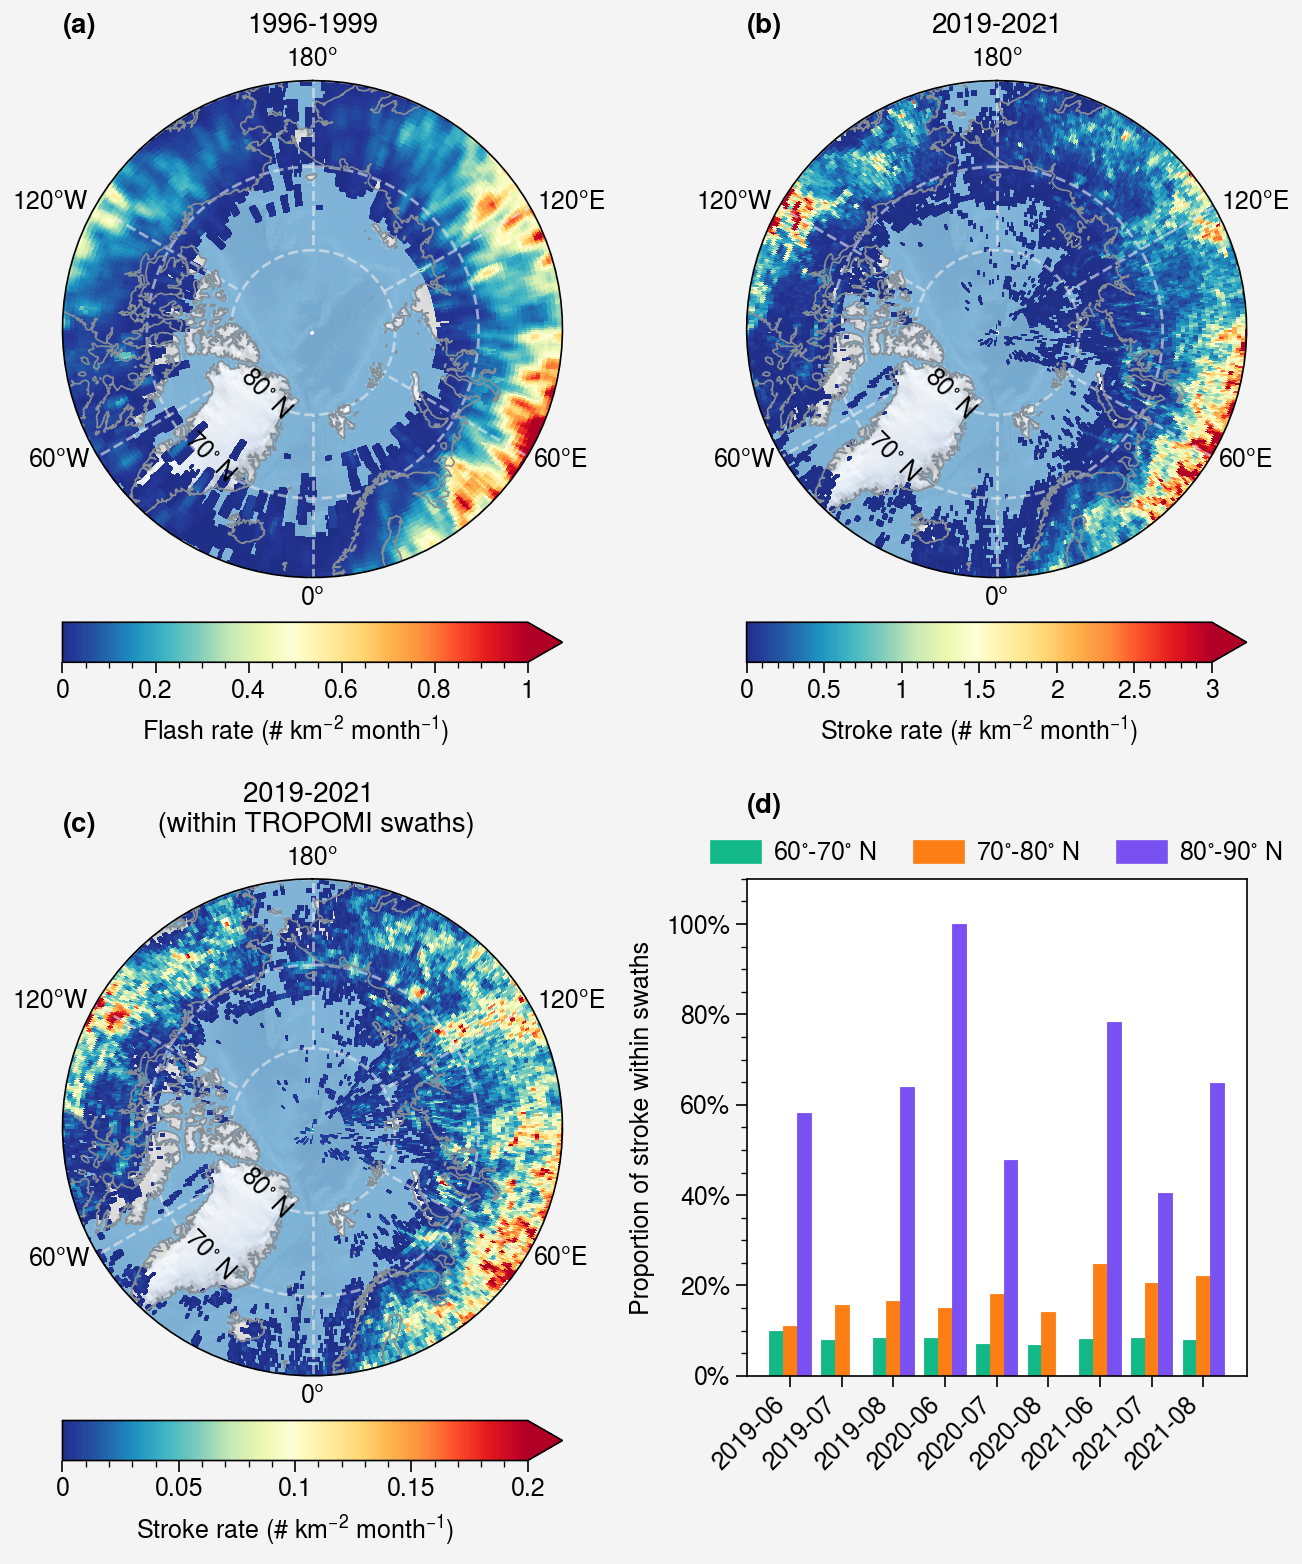

In [14]:
fig, axs = pplt.subplots(nrows=2, ncols=2, proj=['npstere', 'npstere', 'npstere', None])

axs.format(abc='(a)', reso='med', latlines=10, gridcolor='gray2', gridlinewidth=1, gridalpha=0.6, gridlinestyle='--',
           lonlabels='lrbt', landcolor='gray5', coast=True, coastcolor='gray6',
           )

axs[:3].format(boundinglat=60)

plot_otd(otd_mon.sel(Latitude=slice(None, 75)), axs[0])
plot_lightning_geo(gld360_summer['eventCount'], axs[1], '2019-2021', vmax=3)
plot_lightning_geo(lightning_swath_summer, axs[2], '2019-2021 \n (within TROPOMI swaths)', vmax=0.2)

bar = axs[3].bar(df_lightning_swath_percent, cycle=['teal6', 'orange6', 'violet6'])
bar_1 = mpatches.Patch(color='teal6', label='60$^{\circ}$-70$^{\circ}$ N')
bar_2 = mpatches.Patch(color='orange6', label='70$^{\circ}$-80$^{\circ}$ N')
bar_3 = mpatches.Patch(color='violet6', label='80$^{\circ}$-90$^{\circ}$ N')
axs[3].legend(handles=[bar_1, bar_2, bar_3], loc='t', frame=False)


# set percent axis
axs[3].yaxis.set_major_formatter(PercentFormatter(1))
axs[3].format(grid=False, ylim=(0, 1.1), xlabel='', ylabel='Proportion of stroke within swaths')

# rotate xticklabel
for label in axs[3].get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

axs[:3].stock_img()

def map_annotation(lonlat_list, rotate_deg, anno_text):
    l2 = np.array(lonlat_list)
    # Rotate angle
    angle = rotate_deg
    trans_angle = plt.gca().transData.transform_angles(np.array((angle,)),
                                                       l2.reshape((1, 2)))[0]
    plt.text(l2[0], l2[1] , anno_text,
             rotation=trans_angle, rotation_mode='anchor',
             transform=ccrs.PlateCarree())

axs[:3].text(-42, 66, '70$^{\circ}$ N', rotation=-45, transform=ccrs.PlateCarree())
axs[:3].text(-42, 76, '80$^{\circ}$ N', rotation=-45, transform=ccrs.PlateCarree())

fig.savefig('../figures/distribution.pdf')

(a) Mean OTD lightning flash rate over June--August of 1996--1999;

(b) Mean GLD360 lightning stroke rate over June--August of 2019--2021;

(c) Same as (b) but only counting the lightning inside the TROPOMI swaths during the 6 hour period before the TROPOMI overpass time.
Grids with no lightning are set as transparent in (a)--(c) panels.

(d) The monthly ratio of (c) to (b).

In [15]:
swath_percent = lightning_swath_summer.values/gld360_summer['eventCount'].values
print('ratio of ', np.nanmean(swath_percent))

ratio of  0.24621863748124154


/var/folders/cq/3gpzzbcn09v0cq17f4n6hjcr0000gn/T/ipykernel_10220/4181905558.py:1: RuntimeWarning: invalid value encountered in divide
  swath_percent = lightning_swath_summer.values/gld360_summer['eventCount'].values


In [16]:
print('percentage 60-70 N:', df_lightning_swath_percent['60-70'].min(), '--', df_lightning_swath_percent['60-70'].max())
print('percentage 70-80 N:', df_lightning_swath_percent['70-80'].min(), '--', df_lightning_swath_percent['70-80'].max())
print('percentage 80-90 N:', df_lightning_swath_percent['80-90'].min(), '--', df_lightning_swath_percent['80-90'].max())

percentage 60-70 N: 0.0671419814723614 -- 0.09821862474758357
percentage 70-80 N: 0.11101605073744118 -- 0.24717193092457612
percentage 80-90 N: 0.40384242189016106 -- 1.0


## OTD flash rate variability

In [17]:
# count/km^2/day
ds_otd_month = xr.open_dataset('../data/otd/LISOTD_LRMTS_V2.3.2015.nc', decode_times=False)['LRMTS_COM_FR'].isel(Month_since_Jan_95=[17,18,19,29,30,31,41,42,43,53,54,55])
ds_otd_month = ds_otd_month.where(ds_otd_month['Latitude']<=75)

time = ['1996-06', '1996-07', '1996-08', '1997-06', '1997-07', '1997-08', '1998-06', '1998-07', '1998-08', '1999-06', '1999-07', '1999-08']
ds_otd_month = ds_otd_month.rename({'Month_since_Jan_95': 'time'}).assign_coords({'time':time})

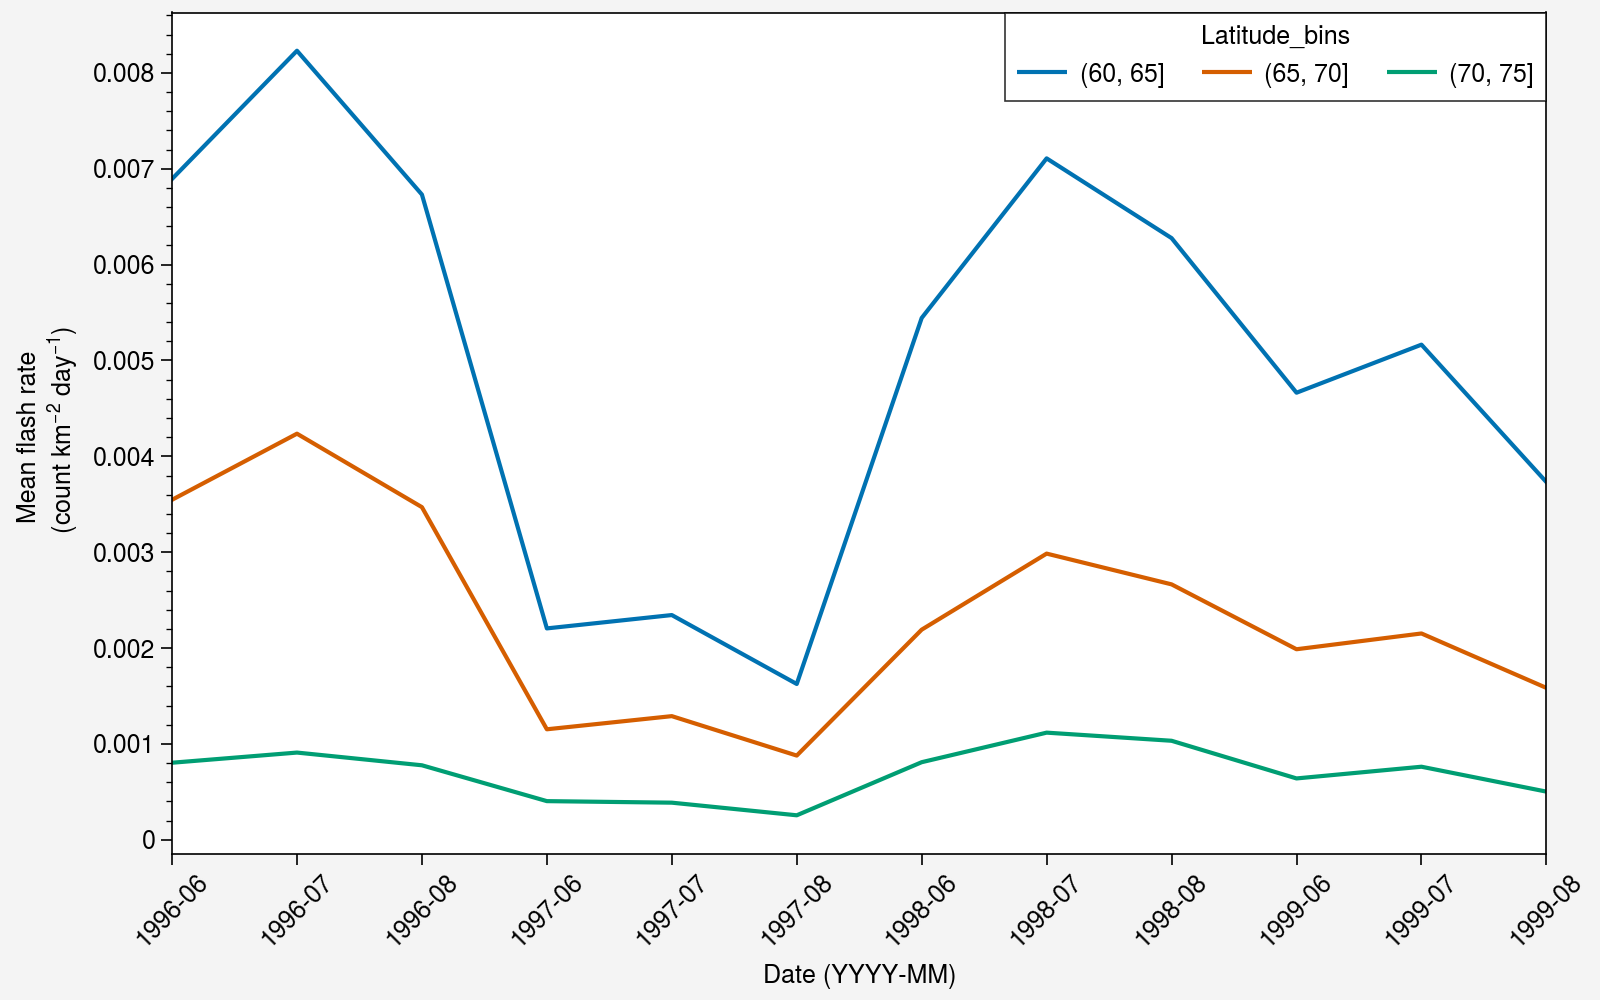

In [18]:
fig, axs = pplt.subplots(figsize=(8,5))

l = ds_otd_month.groupby_bins("Latitude", [60, 65, 70, 75]).mean().mean(['Longitude']).plot(ax=axs, x="time", hue="Latitude_bins")#, add_legend=False)

for tick in axs.get_xticklabels():
    tick.set_rotation(45)

axs.format(grid=False, ylabel='Mean flash rate \n (count km$^{-2}$ day$^{-1}$)',
          xlabel='Date (YYYY-MM)')

fig.savefig('../figures/otd_tseries.pdf')

## ERA5 CAPE variability

In [19]:
ds_cape = xr.open_dataset('../data/era5/era5_monthly_cape.nc')['cape'].coarsen(time=3).mean()

In [20]:
ds_cape.groupby_bins("latitude", [70, 75, 80, 85, 90]).mean().mean(['longitude'])#.mean('latitude_bins')

<xarray.DataArray 'cape' (time: 3, latitude_bins: 4)>
array([[5.451285 , 4.047205 , 4.960885 , 6.527712 ],
       [9.199248 , 5.0966544, 4.9836054, 5.1617403],
       [7.2558894, 4.848499 , 5.5468664, 7.174985 ]], dtype=float32)
Coordinates:
  * time           (time) datetime64[ns] 2019-07-01T08:00:00 ... 2021-07-01T0...
  * latitude_bins  (latitude_bins) object (70, 75] (75, 80] (80, 85] (85, 90]

## MERRA-2 AOD

In [21]:
ds_aod = xr.open_mfdataset('../data/merra2/MERRA2_*.tavgM_2d_aer_Nx.20*.nc4')['TOTEXTTAU'].coarsen(time=3).mean()

In [22]:
gld360_summer_2019['eventCount']

<xarray.DataArray 'eventCount' (longitude: 720, latitude: 60)>
array([[0.00172879, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00178317, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00089158, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00172879, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])
Coordinates:
  * longitude  (longitude) float64 -179.7 -179.2 -178.7 ... 178.8 179.2 179.8
  * latitude   (latitude) float64 60.25 60.75 61.25 61.75 ... 88.75 89.25 89.75
    season     <U3 'JJA'

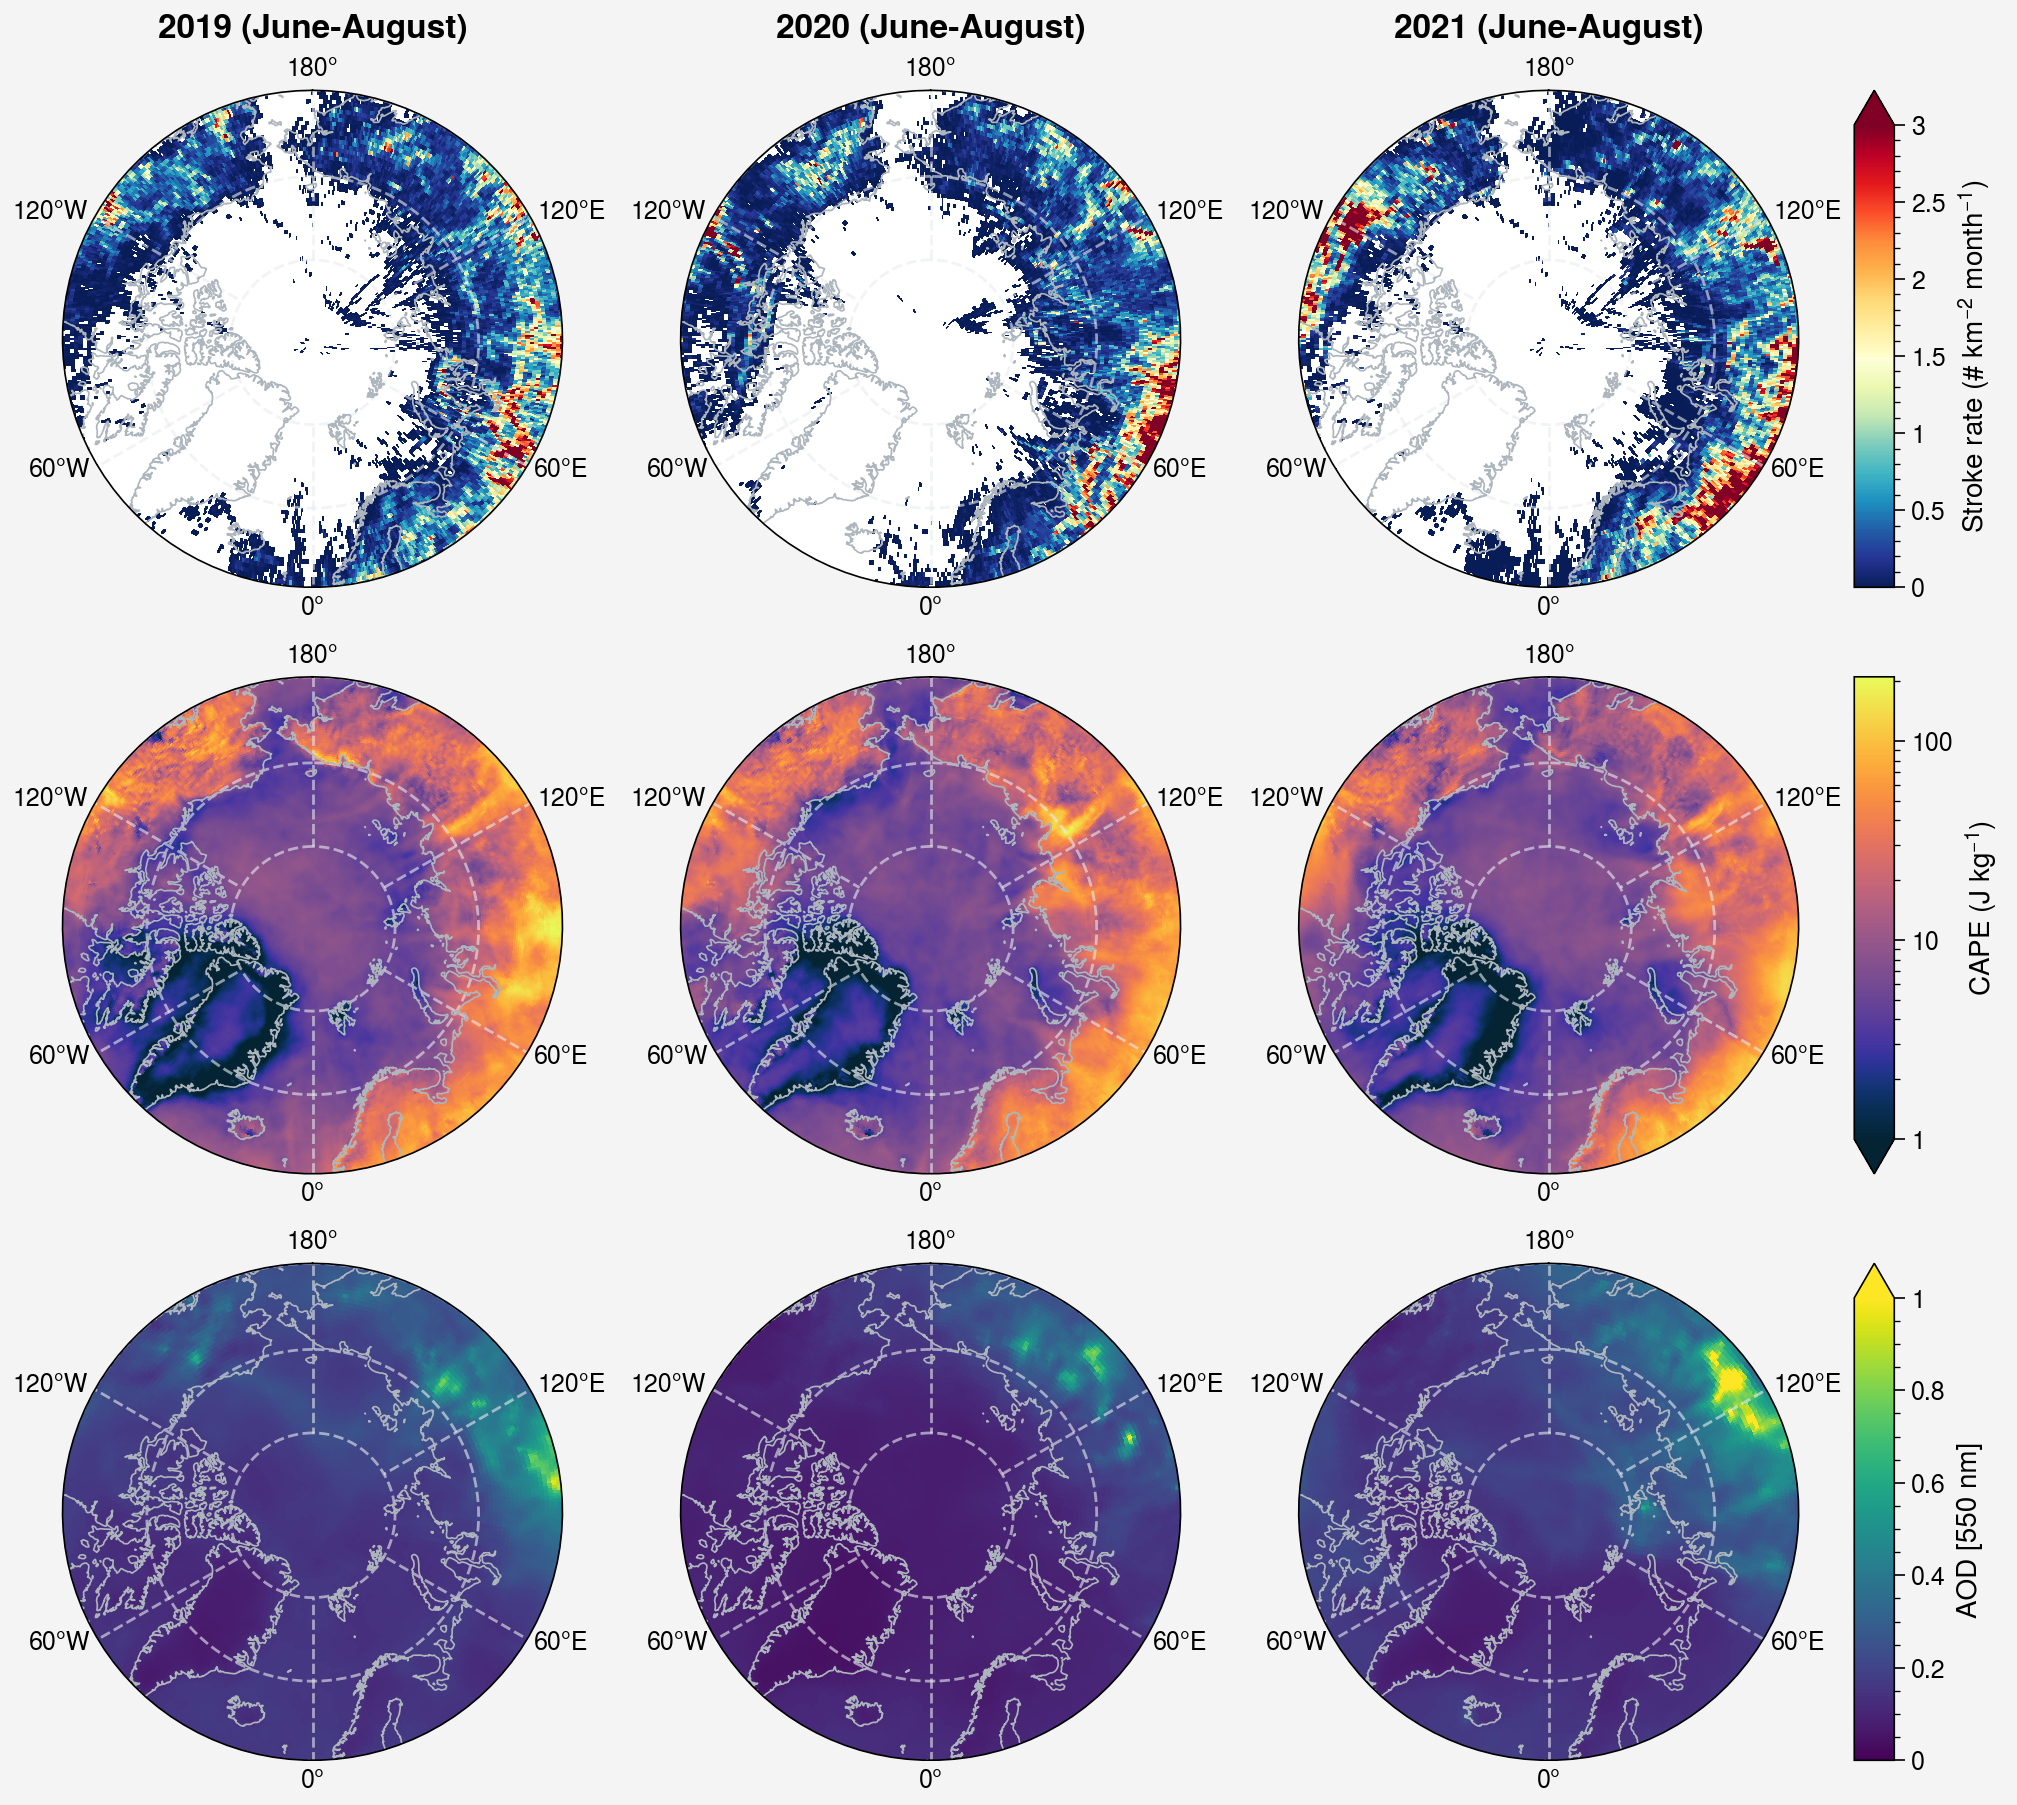

In [23]:
fig, axs = pplt.subplots(nrows=3, ncols=3, proj='npstere')

axs.format(boundinglat=60, latlines=10, coast=True, lonlabels='lrbt', coastcolor='gray5', reso='med', gridcolor='gray2', 
gridlinewidth=1, gridalpha=0.6, gridlinestyle='--',)



cbar_kwargs=dict(extend='max',label='Stroke rate (# km$^{-2}$ month$^{-1}$)', labelsize=10)
gld360_summer_2019['eventCount'].where(gld360_summer_2019['eventCount']>0).plot(ax=axs[0], x='longitude', y='latitude',
                                                                            cmap=cmap, discrete=False, rasterized=True,
                                                                            add_colorbar=False, vmin=0, vmax=3
                                                                            )
gld360_summer_2020['eventCount'].where(gld360_summer_2020['eventCount']>0).plot(ax=axs[1], x='longitude', y='latitude',
                                                                            cmap=cmap, discrete=False, rasterized=True,
                                                                            add_colorbar=False, vmin=0, vmax=3
                                                                            )
gld360_summer_2021['eventCount'].where(gld360_summer_2019['eventCount']>0).plot(ax=axs[2], x='longitude', y='latitude',
                                                                            cmap=cmap, discrete=False, rasterized=True,
                                                                            cbar_kwargs=cbar_kwargs,
                                                                            vmin=0, vmax=3
                                                                            )

for index in [3,4,5]:
    if index == 5:
        add_colorbar = True
        cbar_kwargs=dict(extend='min', label='CAPE (J kg$^{-1}$)', labelsize=10)
    else:
        add_colorbar = False
        cbar_kwargs=None
    ds_cape.where(ds_cape>1, 1).isel(time=index-3).plot(ax=axs[index], norm=LogNorm(), vmax=200,
                                                discrete=False, add_colorbar=add_colorbar,
                                                cbar_kwargs=cbar_kwargs, cmap='Thermal',
                                                rasterized=True
                                                )

for index in [6,7,8]:
    if index == 8:
        add_colorbar = True
        cbar_kwargs=dict(extend='max', label='AOD [550 nm]', labelsize=10)
    else:
        add_colorbar = False
        cbar_kwargs=None
    
    ds_aod.isel(time=index-6).plot(ax=axs[index], discrete=False, add_colorbar=add_colorbar,
                                   cbar_kwargs=cbar_kwargs, cmap='viridis', vmin=0, vmax=1,
                                   rasterized=True)


axs.format(title='', toplabels=['2019 (June-August)', '2020 (June-August)', '2021 (June-August)'],
           toplabelsize=12)

fig.savefig('../figures/cape_aod.pdf')